In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
# Step 1: Load the Data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [5]:
# Check for missing values
print(train_data.isnull().sum())

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


## Feature Engineering

In [6]:
# Feature Encoding
categorical_features = [
    "person_home_ownership",
    "loan_intent",
    "loan_grade",
    "cb_person_default_on_file",
]
numerical_features = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
]

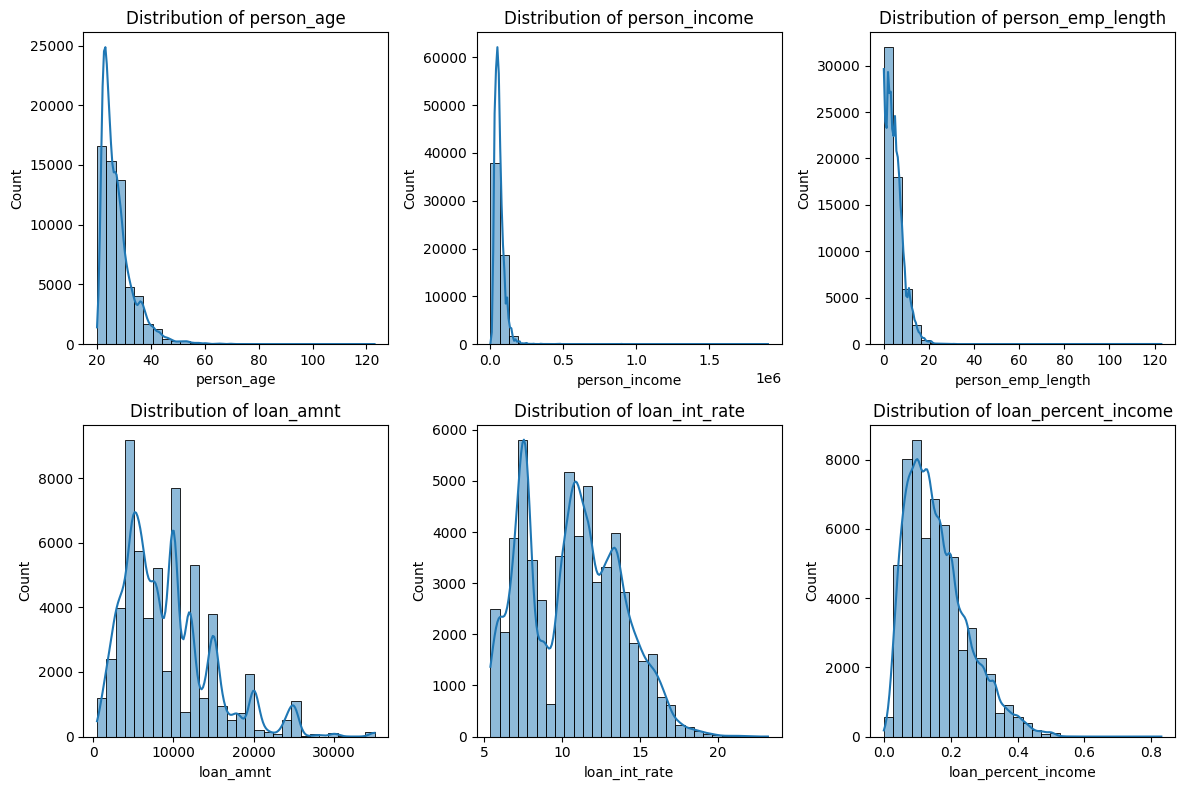

In [7]:
# Visualize the distribution of numerical features
plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train_data[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

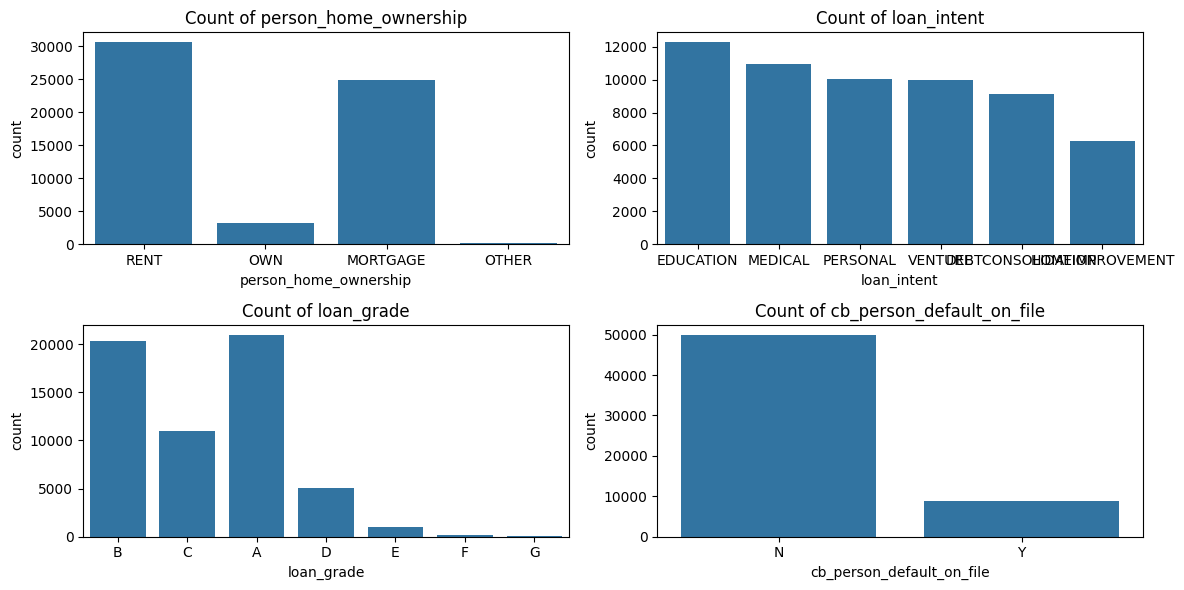

In [8]:
 # Visualize categorical features
plt.figure(figsize=(12, 6))
for i, column in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=train_data, x=column)
    plt.title(f'Count of {column}')
plt.tight_layout()
plt.show()

In [9]:
# Outlier detection and removal
from scipy import stats


# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, threshold=3):
    outliers = []
    for column in df.columns:
        if df[column].dtype in ["int64", "float64"]:
            z_scores = np.abs(stats.zscore(df[column]))
            outliers.append(df[(z_scores > threshold)])
    return outliers


# Apply outlier detection to numerical features
outliers = detect_outliers_zscore(train_data[numerical_features])

# Remove outliers from the dataset
for outlier in outliers:
    # Check if the outlier index exists in the DataFrame
    valid_indices = outlier.index.intersection(train_data.index)
    if not valid_indices.empty:
        train_data = train_data.drop(valid_indices)

In [10]:
# Preprocessing for Numerical Features
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

In [11]:
# Preprocessing for Categorical Features
encoder = OneHotEncoder(sparse_output=False, drop="first")  # Avoid dummy variable trap
encoded_categorical = encoder.fit_transform(train_data[categorical_features])
encoded_categorical_df = pd.DataFrame(
    encoded_categorical, columns=encoder.get_feature_names_out(categorical_features)
)

# Combine the processed features
train_data = pd.concat(
    [
        train_data.drop(categorical_features, axis=1).reset_index(drop=True),
        encoded_categorical_df.reset_index(drop=True),
    ],
    axis=1,
)

In [12]:
# Step 3: Model Building
X = train_data.drop("loan_status", axis=1)
y = train_data["loan_status"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Hyperparameter tuning
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
}

In [14]:
grid_search = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    param_grid,
    cv=3,
    scoring="accuracy",
)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

d:\Study\Projects\Loan Approval Predicton\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Study\Projects\Loan Approval Predicton\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Study\Projects\Loan Approval Predicton\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warning

In [15]:
# Step 4: Model Evaluation
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      9630
           1       0.93      0.72      0.81      1533

    accuracy                           0.95     11163
   macro avg       0.94      0.85      0.89     11163
weighted avg       0.95      0.95      0.95     11163

[[9547   83]
 [ 433 1100]]


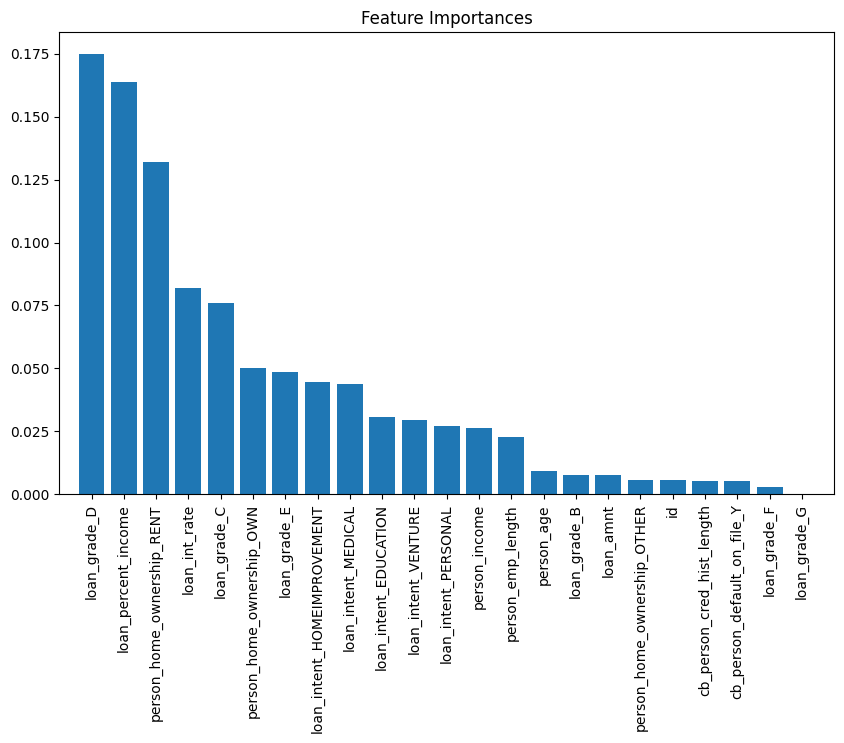

In [16]:
# Feature Importance Plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

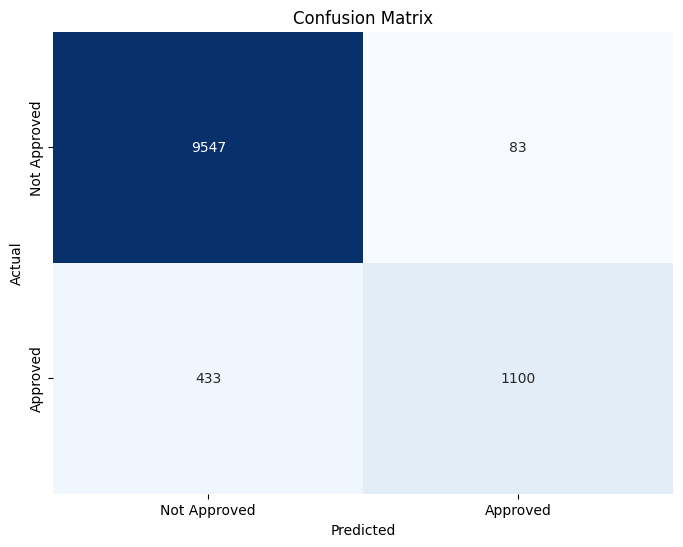

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Approved', 'Approved'], yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
print(accuracy_score(y_val, y_pred))

0.9537758667024994


In [19]:
import pickle

# Save the best model to a pickle file
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

In [20]:
# Load the model from the pickle file
with open("best_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

In [21]:
test_data[numerical_features] = scaler.transform(
    test_data[numerical_features]
)  # Scale numerical features
encoded_test_categorical = encoder.transform(
    test_data[categorical_features]
)  # Encode categorical features
encoded_test_categorical_df = pd.DataFrame(
    encoded_test_categorical,
    columns=encoder.get_feature_names_out(categorical_features),
)

In [22]:
test_data_processed = pd.concat(
    [
        test_data.drop(categorical_features, axis=1).reset_index(drop=True),
        encoded_test_categorical_df.reset_index(drop=True),
    ],
    axis=1,
)

# Step 6: Make Predictions on the Test Data
test_predictions = loaded_model.predict(test_data_processed)

# Optionally, save the predictions to a CSV file
output = pd.DataFrame({"id": test_data["id"], "loan_status": test_predictions})
output.to_csv("submissions.csv", index=False)